In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from statistics import mean
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import KFold

from sklearn.metrics import roc_auc_score

from itertools import combinations

from scipy.special import expit #the logistic function
sigmoid = expit

# Unweighted Similarity based Features

In [2]:
train = pd.read_csv("train_uw_ds/train_uw_20.csv")
test = pd.read_csv("test_uw_ds/test_uw_20.csv")

In [3]:
y = train['Exist']
X = train[['CN', 'AA', 'RA', 'JC', 'PA', 'KI', 'PR']]

In [4]:
# Code adapted from Worksheet04 to calculate the coefficients
clf = LogisticRegression(penalty='none')
clf.fit(X, y)
w_sklearn = np.r_[clf.intercept_, clf.coef_.squeeze()]
print("Weights according to scikit-learn: {}".format(w_sklearn))

Weights according to scikit-learn: [-2.86298014e+00 -2.13459705e-02  8.40868956e+00  4.77521576e+00
  1.09482584e+01  1.24159185e-03  9.76532989e+01  4.35123933e-01]


In [5]:
y_test = test['Exist']
X_test = test[['CN', 'AA', 'RA', 'JC', 'PA', 'KI', 'PR']]
X_test.insert(0,'Intercept',1)

In [8]:
Prob = sigmoid(X_test @ w_sklearn)
test["Predicted"] = Prob 
roc_auc_score(y_test, test['Predicted'])

0.9227608008634838

In [9]:
test['Predicted']

0       1.000000
1       0.976138
2       1.000000
3       0.997351
4       0.525297
          ...   
6409    0.054978
6410    0.054079
6411    0.056429
6412    0.054530
6413    0.061304
Name: Predicted, Length: 6414, dtype: float64

In [6]:
y_test

0       1
1       1
2       1
3       1
4       1
       ..
6409    0
6410    0
6411    0
6412    0
6413    0
Name: Exist, Length: 6414, dtype: int64

# Weak ties with different alphas

In [9]:
alphas = [round(a*0.1,1) for a in range(-30, 31)]
auc_weakties = []
for a in alphas:
    test_w = pd.read_csv("test_alphas/test_w_{}.csv".format(a))
    train_w = pd.read_csv("alphas/train_w_{}.csv".format(a))
    
    weakties = ["WCN", "WAA", "WRA"] # weak ties feature list
    X = train_w[weakties]
    X_test = test_w[weakties]
    X_test.insert(0,'Intercept',1)
    y = train['Exist']
    y_test = test['Exist']
    
    clf = LogisticRegression(penalty='none')
    clf.fit(X, y)
    w_sklearn = np.r_[clf.intercept_, clf.coef_.squeeze()]
    
    predict = sigmoid(X_test @ w_sklearn)
    
    auc_weakties.append(roc_auc_score(y_test, predict))
    
    
auc_weakties = pd.DataFrame(auc_weakties, columns=["AUC"])
auc_weakties.index = alphas
auc_weakties

,AUC
-3.0,0.926881
-2.9,0.926899
-2.8,0.926914
-2.7,0.926932
-2.6,0.926951
...,...
2.6,0.927844
2.7,0.927818
2.8,0.927795
2.9,0.927771


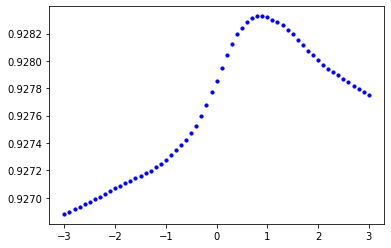

In [10]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(auc_weakties.index, auc_weakties.AUC, s=10, c='b', marker="o")

plt.show()

In [12]:
print('The optimal alpha is {}'.format(auc_weakties.AUC.idxmax()))
print('The optimal AUC is {}'.format(auc_weakties.AUC.max()))

The optimal alpha is 0.8
The optimal AUC is 0.9283272899777139


In [35]:
auc_weakties.to_csv("LG_weakties_auc.csv")

# Node2Vec with different dimensions

In [21]:
ds = [20, 25, 30, 35, 40, 45, 55, 60, 65, 70, 75, 80, 85, 90, 100, 110]
auc_n2v = []
for d in ds:
    train_n2v = pd.read_csv("train_uw_ds/train_uw_{}.csv".format(d))
    test_n2v = pd.read_csv("test_uw_ds/test_uw_{}.csv".format(d))
    n2vF = ["n2v_"+str(i+1) for i in range(d)] # node2vec feature list
    X = train_n2v[n2vF]
    y = train_n2v['Exist']
    X_test = test_n2v[n2vF]
    y_test = test_n2v['Exist']

    
    clf = LogisticRegression(penalty='none')
    clf.fit(X, y)
    w_sklearn = np.r_[clf.intercept_, clf.coef_.squeeze()]
    
    X_test.insert(0,'Intercept',1)
    predict = sigmoid(X_test @ w_sklearn)

    auc_n2v.append(roc_auc_score(y_test, predict))
    
    
auc_n2v = pd.DataFrame(auc_n2v, columns=["AUC"])
auc_n2v.index = ds
auc_n2v

,AUC
20,0.745246
25,0.743504
30,0.743811
35,0.744358
40,0.744707
45,0.737250
55,0.746848
60,0.746396
65,0.745597
70,0.741493


In [34]:
auc_n2v.to_csv("LG_n2v_auc.csv")

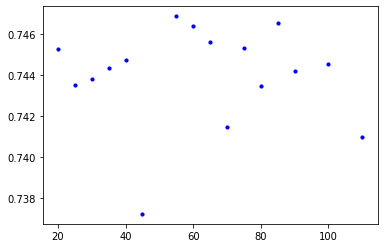

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(auc_n2v.index, auc_n2v.AUC, s=10, c='b', marker="o")

plt.show()

In [23]:
print('The optimal dimension is {}'.format(auc_n2v.AUC.idxmax()))
print('The optimal AUC is {}'.format(auc_n2v.AUC.max()))

The optimal dimension is 55
The optimal AUC is 0.7468484952963336
